# Исследование данных о компьютерных играх 

Проводим исслеодование данных о компьютерных играх, цель - выявить факторы, определяющие успешность игры. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

В нашем распоряжении исторические данные до 2016 года о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation) из открытых источников.

**Описание данных**

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Данные за 2016 год могут быть неполными.


### Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Из общей информации о датафрейме видно, что необходимо будет предобработать данные:

- Привести названия столбцов к нижнему регистру  
- Изменить тип данных в столбцах year_of_release (с float на int),  user_score (на float )  
- Заполнить пропуски данных в столбцах:
    * name
    * year_of_release
    * genre 
    * critic_score
    * user_score
    * rating


### Предобработка данных

#### Заменим названия столбцов (приведем к нижнему регистру)

In [5]:
data.columns = data.columns.str.lower()

#### Проверка на дубликаты

In [6]:
print ("Кол-во явных дубликатов в данных:", data.duplicated().sum())

Кол-во явных дубликатов в данных: 0


In [7]:
print ("Кол-во неявных дубликатов (совпадение по по имени, платформе и году релиза одновременно):", data[['name', 'platform', 'year_of_release']].duplicated().sum())

Кол-во неявных дубликатов (совпадение по по имени, платформе и году релиза одновременно): 2


In [8]:
data[data[['name', 'platform', 'year_of_release']].duplicated()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14244,NaN,GEN,1993.0,NaN,0.0,0.00,0.03,0.0,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.00,0.0,83.0,5.5,E


- Строку 14244 удалим следующим шагом при обработке пропусков
- на повторы с игрой Madden NFL 13 на PS3 and с годом выпуска 2012 посмотрим внимательнее

In [9]:
data.query('name ==  "Madden NFL 13" and platform == "PS3" and year_of_release == 2012')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Можно предположить, что это какая-то техническая ошибка на этапе сбора данных в единую таблицу. Удалим строку 16230 с нулевыми продажами в  NA и JP.

In [10]:
data = data.drop(16230)

#### Обработка пропусков

##### столбец name и genre

In [11]:
data[data.name.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Всего 2 строки имеют пропуски в названии игры, удалим эти строки. Заодно пропусков не останется в столбце genre.

In [12]:
data = data[~(data.name.isna())]

##### столбец year_of_release

In [13]:
print( 'Всего строк с пропущенным значением year_of_release:', data.year_of_release.isna().sum())

Всего строк с пропущенным значением year_of_release: 269


Удалим строки с пропусками в годе выпуска 

In [14]:
data.dropna(subset = ['year_of_release'], inplace = True)

#####     обработка пропусков в столбце critic_score

In [15]:
display (np.sort(data.critic_score.unique()))
print ('Кол-во пропусков в столбце critic_score:', data.critic_score.isna().sum())


array([13., 17., 19., 20., 21., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
       83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.,
       96., 97., 98., nan])

Кол-во пропусков в столбце critic_score: 8461


- Значения в столбце critic_score - это рейтинг по шкале от 0 до 100 (целое число). 
- Пропусков очень много (почти 50%), что может быть обусловлено тем, что либо источник, из которого подтягивались оценки критиков содержал оценки не для всех игр из нашего списка, либо в названиях игр были различия, поэтому оценки не подтянулись. Оставим пропуски как есть.


#####     обработка пропусков в столбце user_score

In [16]:
display (data.user_score.unique())
print ('Колв-во пропусков столбце:', data.user_score.isna().sum())

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Колв-во пропусков столбце: 6605


- Значения в столбце user_score - это рейтинг по шкале от 0 до 10 (с точностью до 1 знака после запятой). 
- Пропусков очень много (около 40%), что может быть обусловлено тем, что либо источник, из которого подтягивались оценки пользователей содержал оценки не для всех игр из нашего списка, либо в названиях игр были различия, поэтому оценки не подтянулись. Оставим пропуски как есть.
- Также в столбце присутуствует значение 'tbd', посмотрим подробнее на эти данные.


In [17]:
print ('Колв-во значений tbd столбце:', data.query('user_score == "tbd"')['user_score'].count())

Колв-во значений tbd столбце: 2376


Проверим 2 предположения, что может означать значение tbd в столбце user_score:
- user_score заполняется значением "tbd", если игра достаточно новая или не очень популярная, т.е. оценки пользователя не опубликованы/отсутствуют. *Для этого проверим игры за какой период имеют такую оценку*
- аналитик, который собирал данные из открытых источников, знал откуда еще можно подтянуть данные с оценками пользователей, но не успел добавить эти данные в общий датасет. *Для этого проверим игры с каких платформ имеют такую оценку*

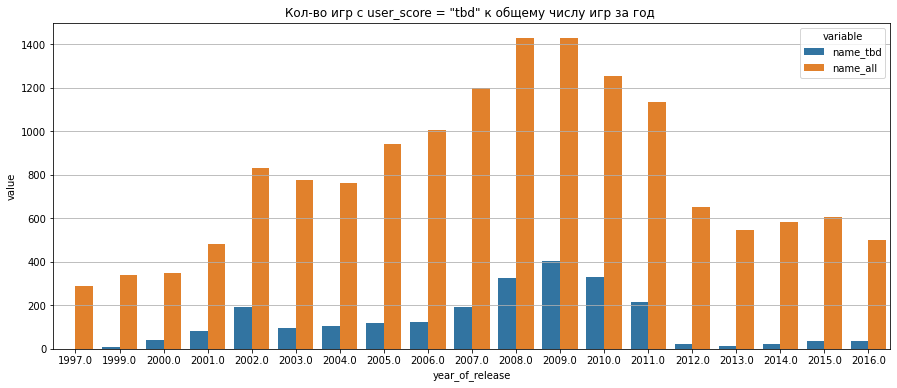

In [18]:
user_score_pivot = (
    data
    .query('user_score == "tbd"')
    .pivot_table(index = ['year_of_release'], values = 'name', aggfunc = 'count')
    .reset_index() # таблица с кол-вом игр, имеющих оценку tbd, по году выпуска
). merge (    
     data.pivot_table(index = ['year_of_release'], values = 'name', aggfunc = 'count').reset_index(), # таблица с общим кол-вом игр по году выпуска
    how = 'left', left_on='year_of_release', right_on='year_of_release', suffixes=('_tbd', '_all') #merge 2 таблицы
    ).melt(id_vars=['year_of_release'], value_vars=['name_tbd', 'name_all']) #преобразуем широкую таблицу в длинную


# строим барплот, на котором будет видно, сколько игр с оценкой tbd по сравнению с общим кол-вом игр за каждый год
fig, ax = plt.subplots(figsize=(15,6))
plt.grid()
plt.title('Кол-во игр с user_score = "tbd" к общему числу игр за год ')
sns.barplot (data = user_score_pivot, x = 'year_of_release', y = 'value', hue = 'variable');
plt.show()

Строки с user_score = "tbd" относятся к играм, которые выходили в период с 1997 по 2016. До 2000 и после 2012 года кол-во игр с tbd значением в столбце user_score очень мало. Больше всего игр с такой оценкой в период с 2008 по 2010 (и в абсолютном, и в относительном выражении). *Проверим зависимость от платформы*

In [19]:
(round(data.query('user_score == "tbd"')['platform'].value_counts()/data['platform'].value_counts(),2)
).to_frame('tbd_to_all').sort_values(by = 'tbd_to_all', ascending = False)

,tbd_to_all
DS,0.35
Wii,0.33
GBA,0.32
GC,0.18
XB,0.18
3DS,0.11
PS2,0.11
PSP,0.10
PS3,0.07
X360,0.07


- Видно, что для примерно половины платформ в колонке user_score не встречается значение tbd. 
- Больше всего оценок tbd у платформ производителя Nintendo: DS, Wii, GBA, GC, 3DS (относительно общего кол-ва игр платформы)

*Похоже, что действительно при сборе данных в общий датафрейм аналитик планировал, но еще не успел подтянуть данные с оценками пользователей из некоторых источников и заполнил эти строки значением tbd.*

**Для дальнейшего анализа заменим tbd на nan.**

In [20]:
print('Кол-во пропусков (nan) в столбце user_score:', data.user_score.isna().sum())
print('Кол-во пропусков (nan) в столбце user_score: после замены tbd на nan', data.user_score.isna().sum() + data.query('user_score == "tbd"').shape[0])

Кол-во пропусков (nan) в столбце user_score: 6605
Кол-во пропусков (nan) в столбце user_score: после замены tbd на nan 8981


In [21]:
data.loc[data.user_score == "tbd", 'user_score'] = np.nan
print(data.user_score.isna().sum())

8981


#####     обработка пропусков в столбце  rating

In [22]:
display(data['rating'].unique())
print('Колв-во пропусков столбце:', data.rating.isna().sum())

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Колв-во пропусков столбце: 6676


- Значения в столбце rating -  рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков». 
- Для удобства ниже создадим таблицу rating_table с расшифровками рейтингов.
- Пропусков очень много (около 40%), что может быть обусловлено тем, что либо ESRB не присвоила рейтинг конкретной игре, либо рейтинг не подтянулся (например,  в названиях игр были различия). Заменим пропуски значением "no rating".


In [23]:
data['rating'].fillna("no rating", inplace = True)

In [24]:
rating_table = pd.DataFrame(data = {'rating':['E', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],\
            'rating_full': ['Everyone', 'Mature 17+', 'Teen 13+', 'Everyone 10+', 'Kids to Adults (changed to E Everyone in 1998)', 'Adults Only 18+', 'Early Childhood (not in use)', 'Rating Pending']})

In [25]:
data[['critic_score', 'user_score', 'rating']].describe(include='all')

,critic_score,user_score,rating
count,7982.000000,7462,16443
unique,NaN,95,9
top,NaN,7.8,no rating
freq,NaN,322,6676
mean,68.992608,NaN,NaN
std,13.920049,NaN,NaN
min,13.000000,NaN,NaN
25%,60.000000,NaN,NaN
50%,71.000000,NaN,NaN
75%,79.000000,NaN,NaN


#### Преобразуем типы данных

In [26]:
data.year_of_release = data.year_of_release.astype('int')

In [27]:
data['user_score'] = data['user_score'].astype('float')

#### Добавление в таблицу новых столбцов

Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец

In [28]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [29]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,no rating,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,no rating,31.38


#### Вывод по предобработке данных.

После предобработки данных из 16715 строк осталось 16443, т.е. была удалена очень малая часть данных (менее 2%), удаление данных не повлияет на ход дальнейшего исследования и не исказит выводы. Что было сделано:
- Привели названия столбцов к нижнему регистру 
- Удалили строки с пропусками в столбцах с названием игры (2 строки) и годом выпуска (269 записей).
- явные дубликаты в данных отсутствовали
- обнаружили и удалили неявные дубликаты, где было совпадение по названию игры, платформы и году выпуска с другой строкой (1 строка)
- значение tbd в столбце user_score заменили на nan
- пропуски в столбцах critic_score, user_score оставили как есть (их больше чем половина значений в каждом столбце), т.к. заменить их нечем, а удалить не можем, т.к. потеряем большую часть данных
- пропуски в столбце rating заменили на "no rating" 


### Исследовательский анализ данных

#### Распределение игр по годам. 
Важны ли данные за все периоды?

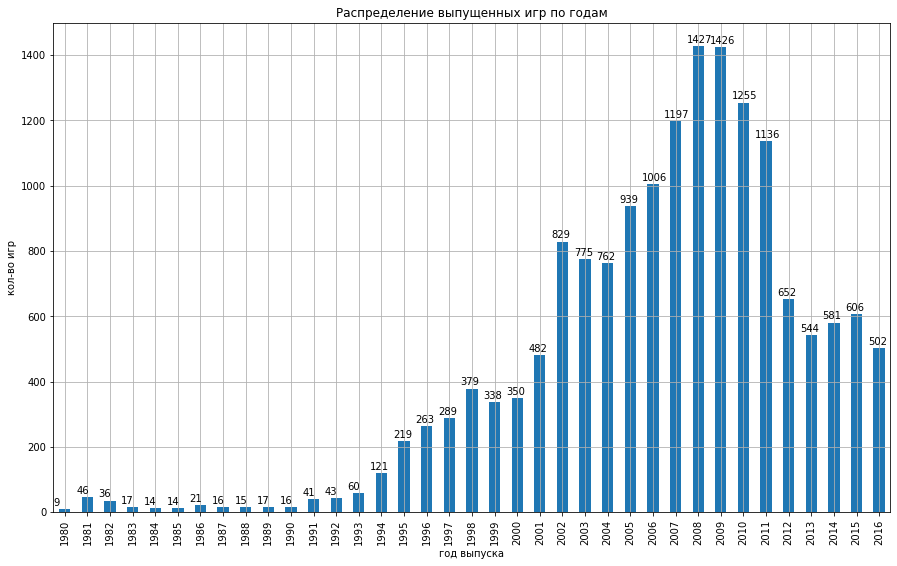

In [30]:
# Построение распределения выпущенных игр по годам
(
    data.year_of_release.value_counts().sort_index()
    .plot(kind = 'bar', grid = True, figsize = (15,9),\
          title='Распределение выпущенных игр по годам', xlabel='год выпуска', ylabel='кол-во игр')
)


# Добавление значений над столбцами
for index, value in enumerate(data.year_of_release.value_counts().sort_index()):
    plt.text(index - 0.5, value + 10, str(value))  # Размещение значения чуть выше столбца

plt.show()

In [31]:
print('Кол-во игр, выпущенных за 2007-2011:', data.query('year_of_release >= 2007 and year_of_release <= 2011').shape[0])

Кол-во игр, выпущенных за 2007-2011: 6441


- Игровая индустрия стала активнее развиваться разваиваться во второй половине 90-х: ежегодно выпускалось на рынок от 200 до 400 игр. 
- В начале двухтысячных произошел скачок в выпуске видеоигр - ежегодно компании стали выпускать 800 - 1000 игр, что в 2 раза больше, чем в конце 90-х.
- Основной пик развития пришелся на 2007 - 2011 гг - за этот период выпустили более 6500 игр (около 40% всех игр по состоянию на 2016).
- С 2012 года произошел заметный спад в кол-ве выпущенных игр: по-видимому, компании-производители сфокусировались на качестве выпускаемых игр, а не на кол-ве.
- Ясно, что рынок игровой индустрии сильно менялся со временем, так что для построения прогнозов на будущее более старые периоды будут уже неактуальны. ***Более точнее определить временной период, за который будем брать данные для построения прогноза, поможет анализ выпуска в разрезе платформ и года выпуска (следующий пункт нашего анализа).***

#### Динамика продаж по платформам. 
Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [32]:
#display(data.groupby('platform')['total_sales'].sum().sort_values(ascending = False))
display(data.groupby('platform')['total_sales'].sum().describe())

count      31.000000
mean      284.334194
std       343.953517
min         0.030000
25%        22.150000
50%       200.040000
75%       301.205000
max      1233.560000
Name: total_sales, dtype: float64

In [33]:
platform_sales = data.groupby(['platform', 'year_of_release'])['total_sales'].sum()
platform_list_sorted = data.groupby('platform')['total_sales'].sum().sort_values(ascending = False)
          
display(platform_list_sorted.head(9).index)

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP'], dtype='object', name='platform')

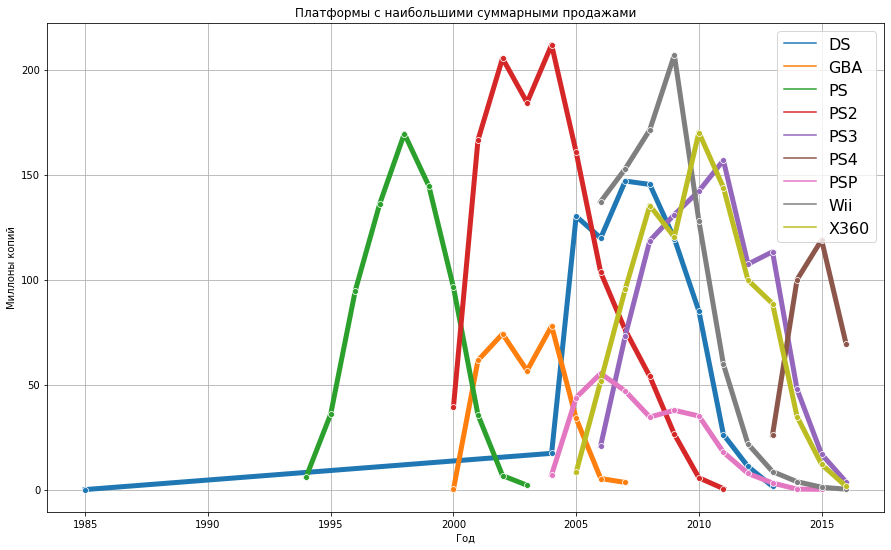

In [34]:
plt.figure(figsize=(15,9))
d = platform_sales.reset_index().query('platform in @platform_list_sorted.head(9).index')
sns.lineplot(data=d, x='year_of_release', y='total_sales', hue='platform', marker='o', linewidth = 5, dashes=False);
plt.title('Платформы с наибольшими суммарными продажами')
plt.xlabel('Год')
plt.ylabel('Миллоны копий')
plt.grid()
plt.legend(loc='upper right', fontsize = 16)
plt.show()

По графику продаж видеоигр в зависимости от года выпуска игры и игровой платформы можно увидеть следующие закономерности:
- у игровых платформ есть средняя продолжительность "жизни": производители выпускают приставку, кол-во проданных игр после выпуска со временем растет, достигая пика в середине "жизни" приставки, затем продажи идут на спад и, в конечном итоге, производитель прекращает поддержку платформы
- приставки PlayStation компании Sony всегда в числе лидеров, и можно заметить, как меняется модельный ряд PS со временем - от модели PS в 90-е до самой новой модели - PS4, выпущенной в 2013.  

Заодно заметили **выброс в данных по платформе Nintendo DS**. По данным из Википедии, релиз приставки DS состоялся в 2004 году, а в нашей таблице есть данные за 1985 год, *вероятно в наших данных ошибка - исправим ее.*

In [35]:
data.query('platform == "DS" and year_of_release < 2003')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,no rating,0.02


In [36]:
data.loc[data.name == "Strongest Tokyo University Shogi DS", 'year_of_release'] = 2005 #внесем исправление в датафрейм data

In [37]:
platform_info = (
    data[['name', 'platform', 'year_of_release', 'total_sales']]
    .groupby('platform')
    .agg(year_min = ('year_of_release', 'min'), year_max = ('year_of_release', 'max'),\
        count = ('name', 'count'), sum_sales = ('total_sales', 'sum'))
    .reset_index()
).sort_values(by = ['year_max', 'sum_sales'], ascending = False)

platform_info['year_delta'] = platform_info['year_max'] - platform_info['year_min'] +1

display(platform_info)

,platform,year_min,year_max,count,sum_sales,year_delta
28,X360,2005,2016,1232,961.24,12
17,PS3,2006,2016,1305,931.33,11
26,Wii,2006,2016,1286,891.18,11
18,PS4,2013,2016,392,314.14,4
2,3DS,2011,2016,512,257.81,6
13,PC,1985,2016,957,255.76,32
30,XOne,2013,2016,247,159.32,4
27,WiiU,2012,2016,147,82.19,5
20,PSV,2011,2016,429,53.81,6
19,PSP,2004,2015,1193,289.53,12


Для оценки средней продолжительности жизни игровых приставок удалим данные о PC, чтобы не искажать результаты

In [38]:
platform_info.query('platform != "PC" ')['year_delta'].describe()

count    30.000000
mean      7.200000
std       3.933937
min       1.000000
25%       4.000000
50%       7.000000
75%      10.750000
max      14.000000
Name: year_delta, dtype: float64

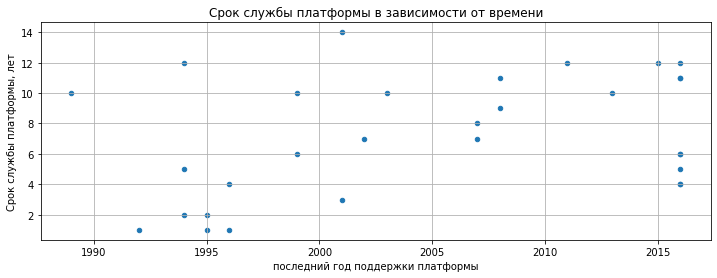

In [39]:
(
    platform_info
    .query('platform != "PC"')
    .plot(kind = 'scatter', x = 'year_max', y = 'year_delta', grid = True, figsize = (12,4), \
         title = "Срок службы платформы в зависимости от времени", xlabel = "последний год поддержки платформы", ylabel = 'Срок службы платформы, лет')
);

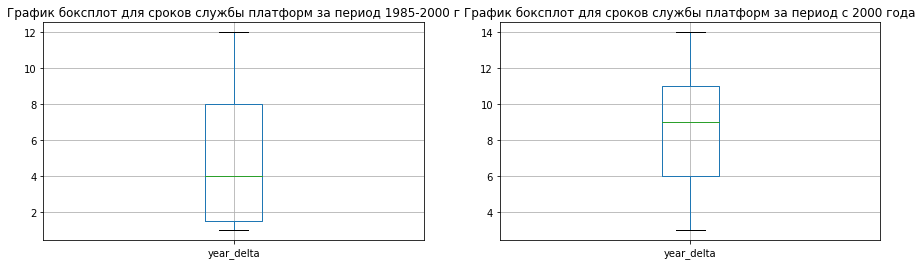

In [40]:
fig, ax = plt.subplots(1,2, figsize = (15,4))

platform_info.query('platform != "PC" and year_max <= 2000').plot(kind = 'box', x = 'year_max', y = 'year_delta', \
                                                                  grid = True, ax = ax[0], title = 'График боксплот для сроков службы платформ за период 1985-2000 г',\
                                                                 xlabel = 'срок службы приставки')
platform_info.query('platform != "PC" and year_max > 2000').plot(kind = 'box', x = 'year_max', y = 'year_delta',\
                                                                 grid = True, ax = ax[1], title = 'График боксплот для сроков службы платформ за период с 2000 года',\
                                                                xlabel = 'срок службы приставки')

plt.show()

In [41]:
platform_info.query('platform != "PC" and year_max > 2000')['year_delta'].describe()

count    19.000000
mean      8.526316
std       3.255225
min       3.000000
25%       6.000000
50%       9.000000
75%      11.000000
max      14.000000
Name: year_delta, dtype: float64

- Установили, что характерный срок службы современных игровых платформ - это 9 лет. 
- Отдельного рассмотрения заслуживают игры на ПК, по которым есть данные с 1985 по 2016 год.


#### Выбор актуального периода. 

Для целей прогнозирования продаж на следующий год выберем временной интервал с 2014 по 2016 год с учетом следующих соображений:

*даже в традиционных бизнесах редко берут данные более чем за 2-3 года. А в такой динамично меняющейся индустрии, как компьютерные игры и вовсе не стоит брать слишком большой временной интервал - иначе обязательно захватим уже отжившие тренды. Но и очень короткий период не подходит для прогнозирования, так что надо выбирать золотую середину (но не менее 2-х полных лет и не более 5 лет, включая 2016 год*

In [42]:
data_analyzed = data.query('year_of_release >= 2014')
display(data_analyzed.shape[0])

1689

#### Какие платформы лидируют по продажам, растут или падают? 
Выберите несколько потенциально прибыльных платформ.

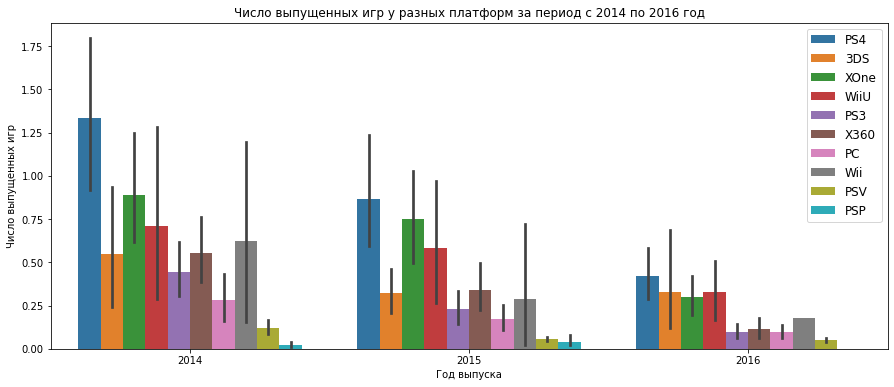

In [43]:
# график с информацией по продажам игр в разрезе года и платформы
plt.figure(figsize=(15, 6))

plt.title("Число выпущенных игр у разных платформ за период с 2014 по 2016 год")
sns.barplot(
    data=data_analyzed,
    x='year_of_release',
    y="total_sales",
    hue = 'platform' 
)
plt.xlabel("Год выпуска")
plt.ylabel("Число выпущенных игр")
plt.legend(loc='upper right', fontsize = 12)

- Платформа PS4 - лидер по продажам игр
- Второе место по продажам у платформы XOne (вообще, по данным 2016 года 3DSи WIIU немного перегнали XOne, но помним, что за 2016 год наши данные неполные)
- 3DS на 2016г находится в эксплуатации уже 7 лет, можно ожидать, что в 2017 году продажи 3DS еще снизятся 
- На ПК продажи сильно уступают продажам игр на приставках.

**Потенциально прибыльными платформами на 2017 год можно назвать PS4 и XOne**


#### График «ящик с усами» по глобальным продажам игр в разбивке по платформам.
*Опишите результат.*

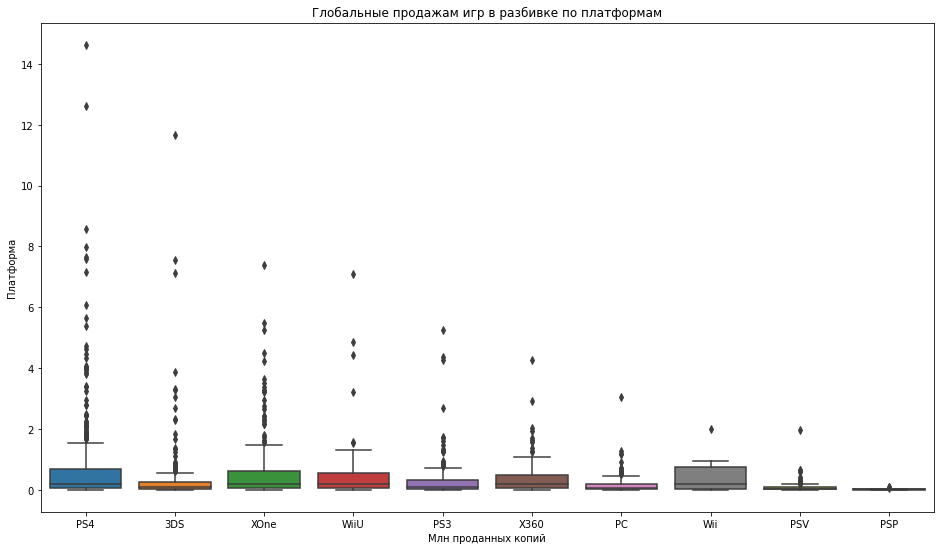

In [44]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(
    data=data_analyzed, 
    y="total_sales", 
    x="platform"
).set(title = 'Глобальные продажам игр в разбивке по платформам')

plt.xlabel("Млн проданных копий")
plt.ylabel("Платформа")

plt.show()


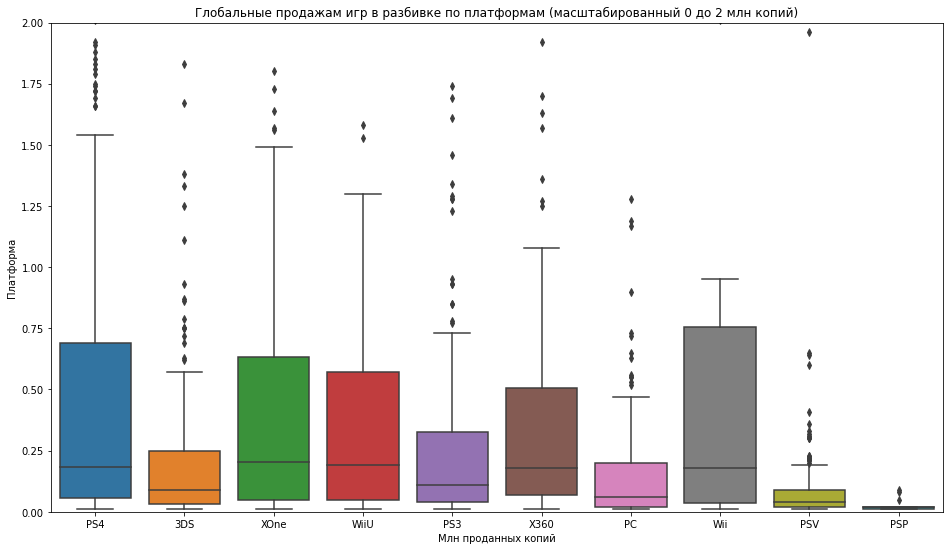

In [45]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(
    data=data_analyzed, 
    y="total_sales", 
    x="platform"
).set(title = 'Глобальные продажам игр в разбивке по платформам (масштабированный 0 до 2 млн копий)')

plt.ylim(0,2)
plt.xlabel("Млн проданных копий")
plt.ylabel("Платформа")

plt.show()


По графику боксплот можно сделать следующие выводы:
- Примерно половина всех игр продается в кол-ве сотен тысяч копий
- У всех платформ есть очень популярные игры, число проданных копий которых исчисляется миллионами
- у платформ PS4 и 3DS есть игры, которые продавались >10 млн копий

#### Влияние отзывов пользователей и критиков на продажи внутри одной популярной платформы . 

*Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. 
Сформулируйте выводы.*

Рассмотрим зависимость продаж от отзывов для самой популярной современной платформы - PS4 

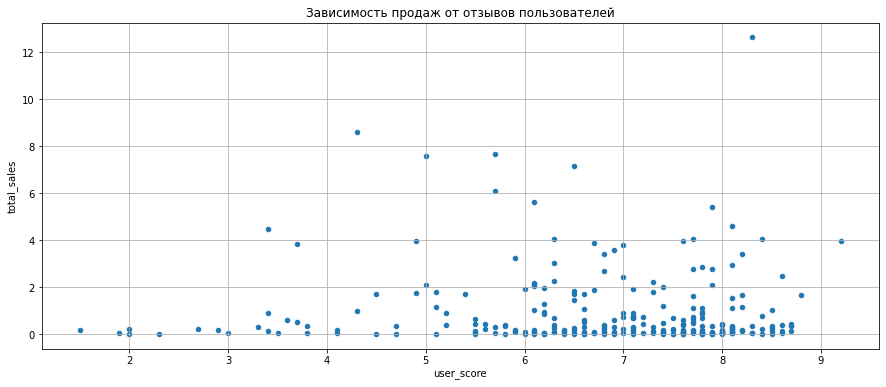

In [46]:
(
    data
    .query('platform == "PS4"')
    .plot(kind = 'scatter', x = 'user_score', y = 'total_sales', grid = True, figsize = (15,6),\
            title = 'Зависимость продаж от отзывов пользователей')
);

In [47]:
print('Коэффициент корреляции кол-ва проданных копий игры и оценки пользователей:')
display(
    data.loc[(data['platform'] == 'PS4'), 'total_sales']
    .corr(data.loc[(data['platform'] == 'PS4'), 'user_score'])
)

Коэффициент корреляции кол-ва проданных копий игры и оценки пользователей:


-0.031957110204556376

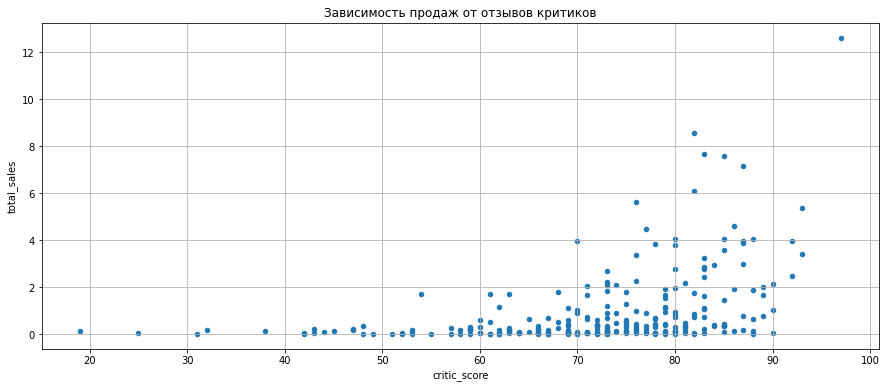

In [48]:
(
    data
    .query('platform == "PS4"')
    .plot(kind = 'scatter', x = 'critic_score', y = 'total_sales', grid = True, figsize = (15,6),\
            title = 'Зависимость продаж от отзывов критиков')
);

In [49]:
print('Коэффициент корреляции кол-ва проданных копий игры и оценки критиков:')
display(
    data.loc[(data['platform'] == 'PS4'), 'total_sales']
    .corr(data.loc[(data['platform'] == 'PS4'), 'critic_score'])
)

Коэффициент корреляции кол-ва проданных копий игры и оценки критиков:


0.406567902061781

Из анализа графиков и по значению рассчитанных коэффициентов корреляции можно сделать следующие выводы:
- для платформы PS4 прямой взаимосвязи между оценками пользователей и продажами нет
- для платформы PS4 есть слабая связь между оценками критиков и продажами (коэффициент корреляции 0.4)

##### Соотнесем выводы с продажами игр на других платформах.

In [50]:
# рассмотрим взаимосвязь продаж с оценками пользователей и критиков для платформ из списка p_list
p_list = ['3DS', 'XOne', 'WiiU' ,'PS3']

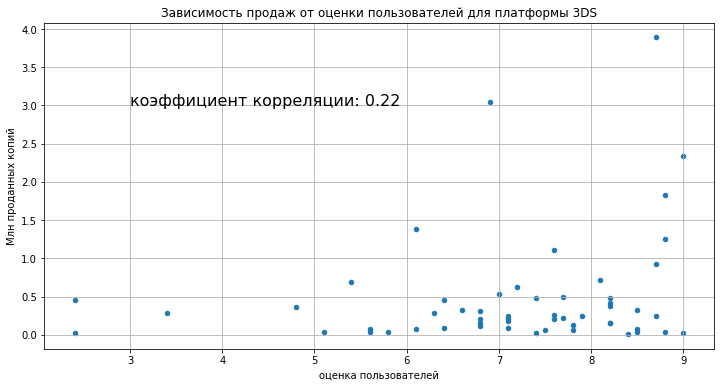

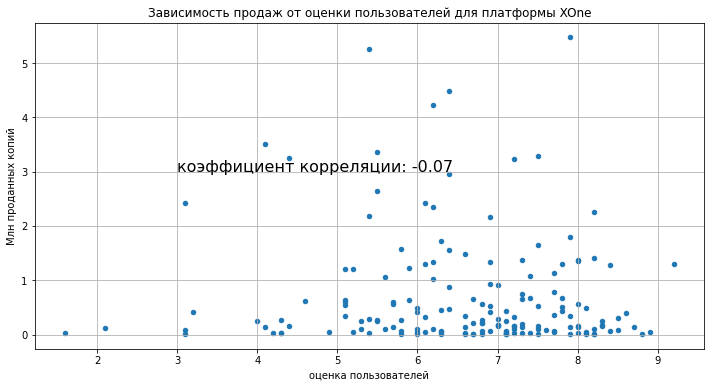

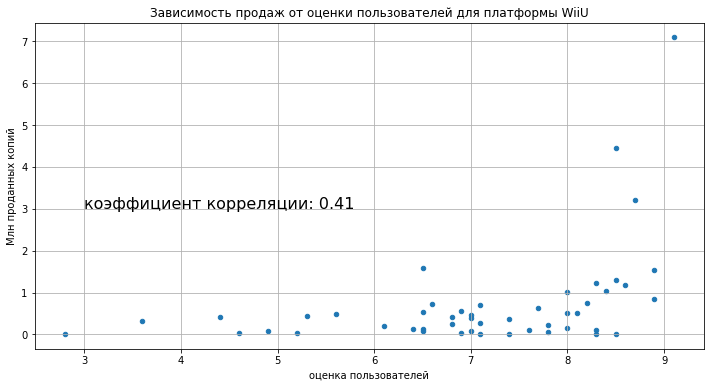

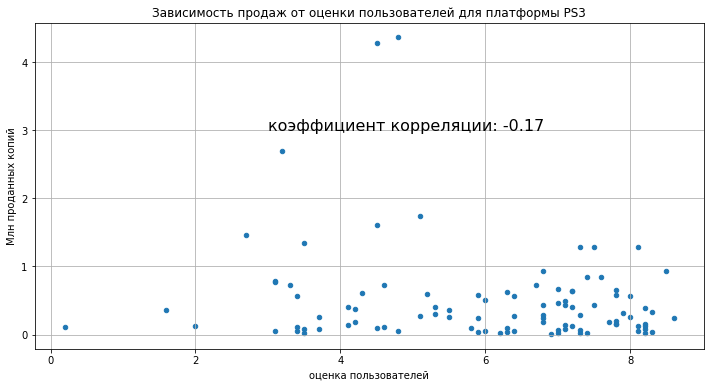

In [51]:
for p in p_list:
    corr_p = data_analyzed.loc[(data_analyzed['platform'] == p), 'total_sales'].corr(data_analyzed.loc[(data_analyzed['platform'] == p), 'user_score'])
    (data_analyzed.query('platform == @p').plot(kind = 'scatter', x = 'user_score', y = 'total_sales',\
                                                       grid = True, figsize = (12,6), title = f'Зависимость продаж от оценки пользователей для платформы {p}',\
                                               xlabel = 'оценка пользователей', ylabel = 'Млн проданных копий'));
    plt.text(3,3, 'коэффициент корреляции: ' + str(round(corr_p, 2)), fontsize = 16)


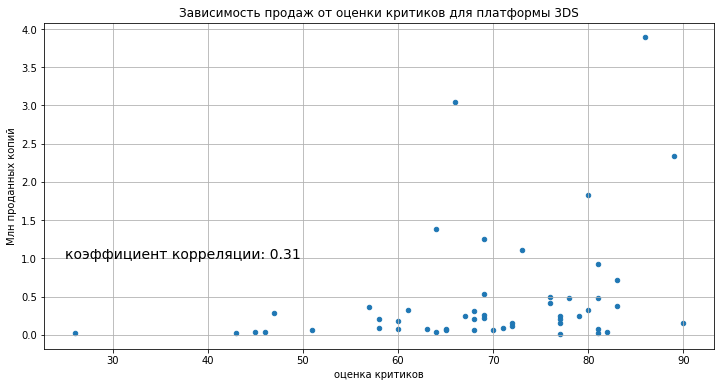

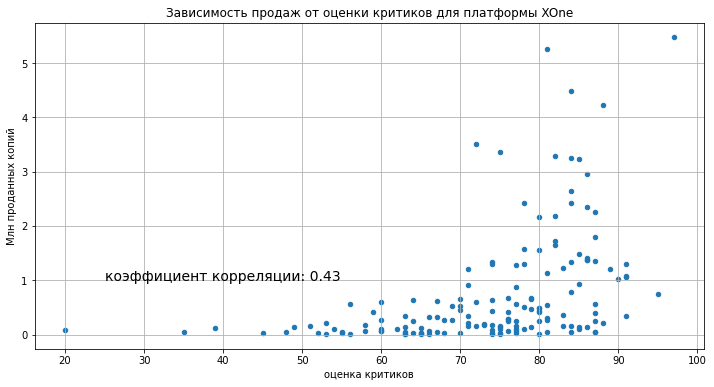

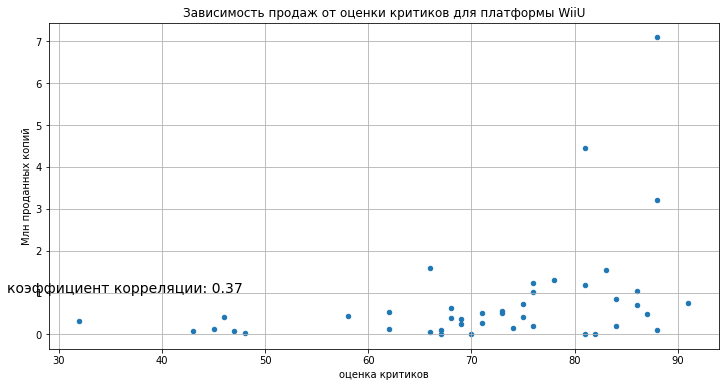

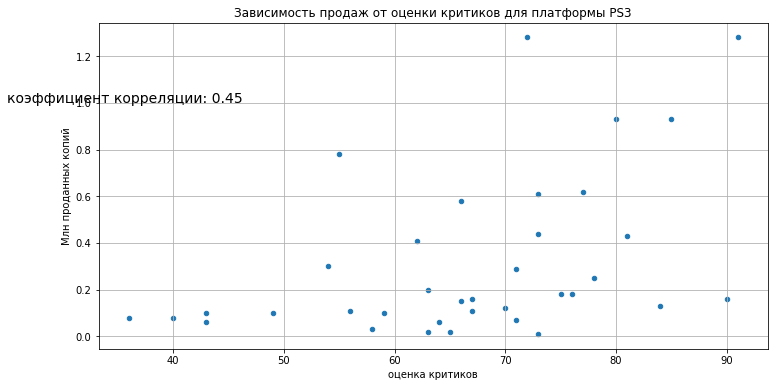

In [52]:
for p in p_list:
    corr_p = data_analyzed.loc[(data_analyzed['platform'] == p), 'total_sales'].corr(data_analyzed.loc[(data_analyzed['platform'] == p), 'critic_score'])
    data_analyzed.query('platform == @p').plot(kind = 'scatter', x = 'critic_score', y = 'total_sales',\
                                                       grid = True, figsize = (12,6), title = f'Зависимость продаж от оценки критиков для платформы {p}',\
                                               xlabel = 'оценка критиков', ylabel = 'Млн проданных копий');
    plt.text(25,1, 'коэффициент корреляции: ' + str(round(corr_p, 2)), fontsize = 14)


In [53]:
print('Коэффициент корреляции кол-ва проданных копий игры и оценки критиков:')
for p in data_analyzed.platform.unique():
    print (p, ":", data_analyzed.loc[(data_analyzed['platform'] == p), 'total_sales']
    .corr(data_analyzed.loc[(data_analyzed['platform'] == p), 'critic_score']))

Коэффициент корреляции кол-ва проданных копий игры и оценки критиков:
PS4 : 0.40266141068104083
3DS : 0.31411749286905105
XOne : 0.42867694370333226
WiiU : 0.370201412480884
PS3 : 0.44657460493190704
X360 : 0.5257228356581523
PC : 0.17463413769350036
Wii : nan
PSV : 0.04266490657009526
PSP : nan


Анализ по всем платформам подтверждает закономерноесть:
- оценки пользователей не влияют на объем продаж (корреляция близка к "0"). *Исключение - платформа WiiU, но как показано ниже для этой платформы почти 40% строк содержат пропуски в столбце с оценками пользователей, так что данные могут быть сильно искажены*
- есть слабая связь между продажами и оценкой критиков 

In [54]:
data_analyzed.query('platform == "WiiU"').critic_score.value_counts(dropna = False, normalize = True)

NaN     0.410959
76.0    0.041096
88.0    0.041096
81.0    0.041096
71.0    0.027397
69.0    0.027397
62.0    0.027397
84.0    0.027397
73.0    0.027397
86.0    0.027397
66.0    0.027397
75.0    0.027397
67.0    0.027397
68.0    0.027397
46.0    0.013699
78.0    0.013699
83.0    0.013699
47.0    0.013699
45.0    0.013699
74.0    0.013699
91.0    0.013699
32.0    0.013699
70.0    0.013699
87.0    0.013699
82.0    0.013699
58.0    0.013699
48.0    0.013699
43.0    0.013699
Name: critic_score, dtype: float64

#### Общее распределение игр по жанрам. 
*Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?*

</font><font color='Blue'><b>Комментарий студента</b></font><br> Поправила выбор данных для датфрейма data_analyzed - теперь там данные за актуальный период 

In [55]:
# Комментарий ревьюера
data.year_of_release.min()

1980

In [56]:
data_genre_agg = (
    data_analyzed
    .groupby('genre')
    .agg(count = ('name', 'count'), median = ('total_sales', 'median'), total_sales = ('total_sales', 'sum'))
    .sort_values(by = 'total_sales', ascending = False)
)

display(data_genre_agg)

,count,median,total_sales
genre,,,
Action,619,0.090,199.36
Shooter,128,0.515,170.94
Sports,161,0.180,109.48
Role-Playing,221,0.110,101.44
Misc,113,0.090,37.55
Fighting,60,0.125,28.22
Racing,69,0.090,27.52
Platform,38,0.140,18.09
Adventure,185,0.030,17.55


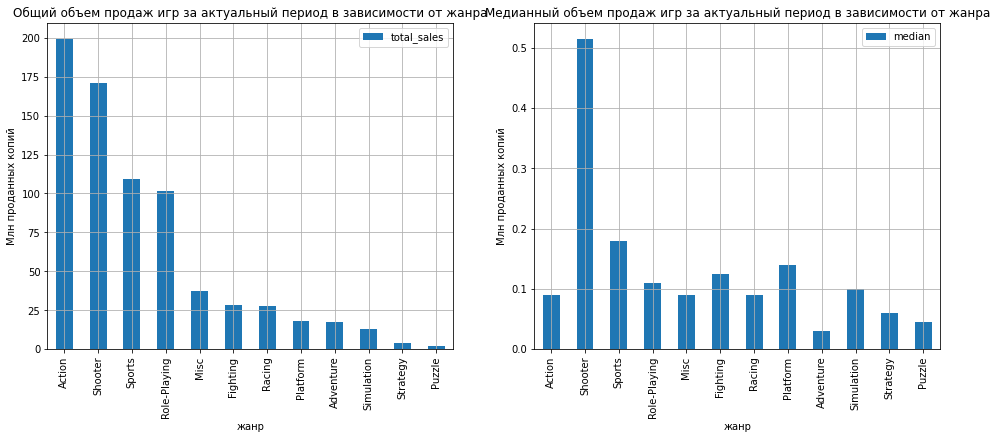

In [57]:
fig, ax = plt.subplots(1,2, figsize = (16,6))
data_genre_agg.reset_index().plot(kind = 'bar', x = 'genre', y = 'total_sales',\
                                  grid = True, title = 'Общий объем продаж игр за актуальный период в зависимости от жанра',\
                                 xlabel = 'жанр', ylabel = 'Млн проданных копий', ax = ax[0])

data_genre_agg.reset_index().plot(kind = 'bar', x = 'genre', y = 'median',\
                                  grid = True, title = 'Медианный объем продаж игр за актуальный период в зависимости от жанра',\
                                 xlabel = 'жанр', ylabel = 'Млн проданных копий', ax = ax[1])

plt.show()

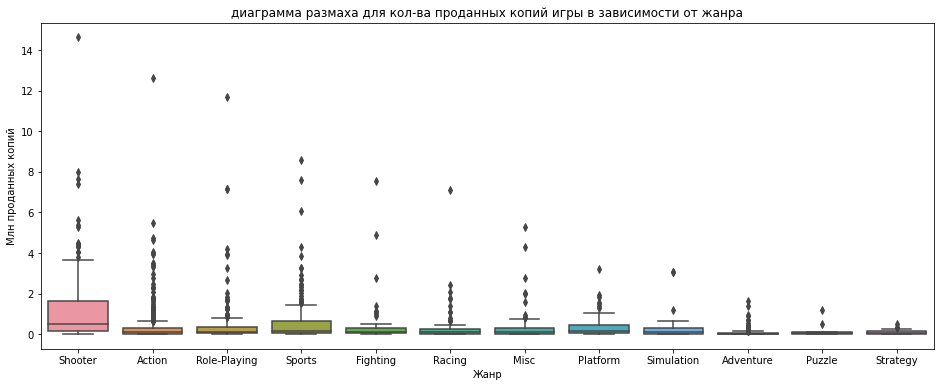

In [58]:
plt.subplots(figsize = (16,6))
sns.boxplot (data = data_analyzed, x = 'genre', y = 'total_sales');
plt.title('диаграмма размаха для кол-ва проданных копий игры в зависимости от жанра')
plt.ylabel("Млн проданных копий")
plt.xlabel("Жанр")

plt.show()


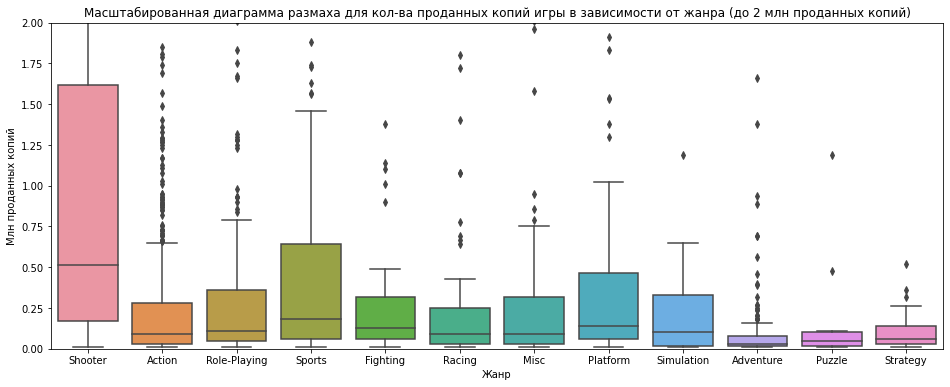

In [59]:
plt.subplots(figsize = (16,6))
sns.boxplot (data = data_analyzed, x = 'genre', y = 'total_sales');
plt.title('Масштабированная диаграмма размаха для кол-ва проданных копий игры в зависимости от жанра (до 2 млн проданных копий)')
plt.ylabel("Млн проданных копий")
plt.xlabel("Жанр")
plt.ylim(0,2)
plt.show()

По графику боксплот хорошо видно, что для рынка видеоигр, независимо от жанра, характерна ситуация, когда большая часть выпущенных игр продается в объеме не превышающем 1 млн копий (исключение - жанр Shooter, для этого жанра и медиана сильно выше, чем у остальных жанров, и "прямоугольник" графика с усами значительно выше, чем у других). При этом характерно большое кол-во выбросов - популярных среди пользователей игр, для которых объем продаж составил >1-2 млн. За период 2014-2016 есть даже 3 игры, у которых кол-во проданных копий перевалило за  10 млн.

Отдельно посмотрим, что это за игры.

In [60]:
data_analyzed.query('total_sales > 10')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,no rating,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,no rating,11.68


- Action - жанр с самым высоким совокупным объемом продаж за актуальный период - 200 млн проданных копий за 2014 - 2016 года. Однако, и конкуренция среди игр в этом жанре самая высокая, так что медианный объем продаж  составляет всего менее 100к копий, что ниже, чем у многих других жанров
- Shooter - жанр с самым высоким медианным объемом продаж за актуальный период (2014-2016г) и второй по совокупному объему продаж за рассматриваемый период (около 170 млн проданных копий). Шутеры выгодно отличаются на фоне всех остальных игр с т.з. объемов продаж, что явно видно на графике боксплот.
- Наименее популярные жанры - Puzzle, Strategy, Simulation . 

### Портрет пользователя каждого региона

Определите для пользователя каждого региона (NA, EU, JP):

#### Самые популярные платформы (топ-5). 
*Опишите различия в долях продаж.*

In [61]:
sales_pivot = data_analyzed.pivot_table(index = ['platform'], values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum').reset_index()

top_platforms = []
top_platforms.append(sales_pivot.sort_values(by = 'na_sales', ascending = False).head()['platform'].values)
top_platforms.append(sales_pivot.sort_values(by = 'eu_sales', ascending = False).head()['platform'].values)
top_platforms.append(sales_pivot.sort_values(by = 'jp_sales', ascending = False).head()['platform'].values)

print('Топ-5 игровых платформ для пользователей NA, EU, JP:')
display( pd.DataFrame(top_platforms, index = ['na_sales','eu_sales','jp_sales'], columns = ['top1', 'top2', 'top3', 'top4', 'top5']))


Топ-5 игровых платформ для пользователей NA, EU, JP:


,top1,top2,top3,top4,top5
na_sales,PS4,XOne,X360,3DS,PS3
eu_sales,PS4,XOne,PS3,PC,3DS
jp_sales,3DS,PS4,PSV,PS3,WiiU


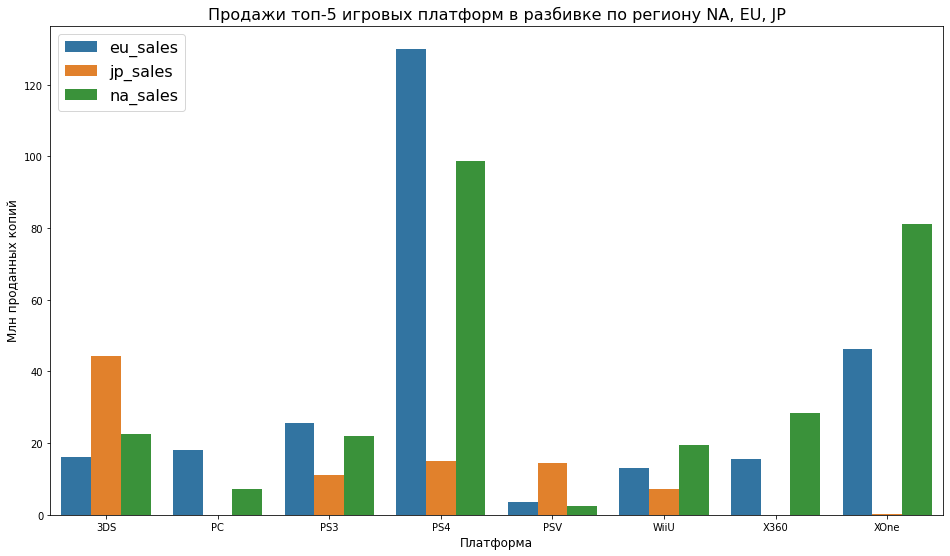

In [62]:
plt.subplots(figsize = (16,9))


sns.barplot(
    data = (
        data_analyzed.iloc[ :, [0,1,2,3,4,5,6,10]]
        .query('platform in ["PS4", "XOne", "X360", "3DS", "PS3", "PC", "PSV", "WiiU"]')
        .melt(id_vars = [ 'platform'], value_vars = ['na_sales', 'eu_sales', 'jp_sales'])
        .groupby(['platform', 'variable'])
        .agg(sales = ('value', 'sum'))
        .reset_index()
    ),
    x = 'platform',
    y = 'sales',
    hue = 'variable',
    
);
plt.title('Продажи топ-5 игровых платформ в разбивке по региону NA, EU, JP', fontsize = 16)
plt.xlabel('Платформа', fontsize = 12)
plt.ylabel('Млн проданных копий', fontsize = 12)
plt.legend(loc='upper left', fontsize = 16);


- В Европе самые популярная приставка за актуальный период - PS4 от Sony (с объемом продаж свыше 120 млн копий),на втором месте с большом отрывом от лидера - XBox One (около 50 млн проданных копий), 3-5 место с примерно одинаковыми продажами - PS3, PC, 3DS. 
- В США также топ-2 игровые приставки - это PS4 (чуть менее 100 млн проданных копий) и XBoxOne (около 80 млн копий). 3-5 место  - XBox 360, 3DS, PS3. 
- В Японии в топ-5 приставок присутствуют только приставки, выпущенные японскими компаниями Nintendo и Sony. Интересно, что популярная среди европейцев и американцев XBox 360 у японцев имеет явный провал. Этот факт подтверждается информацией из интернета - Xbox с трудом отвоевывает свою долю рынка в Японии, не пользуясь там большой популярностью.

*Совокупно пользователи из США и Европы покупают больше игр, чем пользователи из Японии*

#### Самые популярные жанры (топ-5). 
*Поясните разницу.*

In [63]:
sales_pivot = data_analyzed.pivot_table(index = ['genre'], values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum').reset_index()


top_genres = []
top_genres.append(sales_pivot.sort_values(by = 'na_sales', ascending = False).head()['genre'].values)
top_genres.append(sales_pivot.sort_values(by = 'eu_sales', ascending = False).head()['genre'].values)
top_genres.append(sales_pivot.sort_values(by = 'jp_sales', ascending = False).head()['genre'].values)

print('Топ-5 жанров игр для пользователей NA, EU, JP:')
display( pd.DataFrame(top_genres, index = ['na_sales','eu_sales','jp_sales'], columns = ['top1', 'top2', 'top3', 'top4', 'top5']))


Топ-5 жанров игр для пользователей NA, EU, JP:


,top1,top2,top3,top4,top5
na_sales,Shooter,Action,Sports,Role-Playing,Misc
eu_sales,Action,Shooter,Sports,Role-Playing,Racing
jp_sales,Role-Playing,Action,Fighting,Misc,Shooter


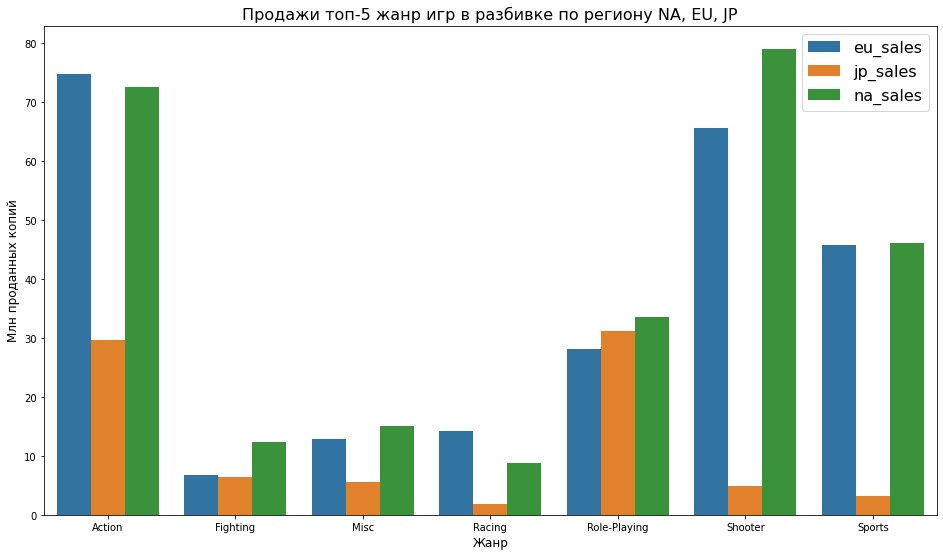

In [64]:
plt.subplots(figsize = (16,9))

sns.barplot(
    data = (
        data_analyzed
        .iloc[:, [0,1,2,3,4,5,6,10]]
        .query( 'genre in["Action", "Sports", "Role-Playing", "Shooter", "Fighting", "Racing", "Misc"]')
        .melt(id_vars = [  'genre'], value_vars = ['na_sales', 'eu_sales', 'jp_sales'])
        .groupby(['genre', 'variable'])
        .agg(sales = ('value', 'sum'))
        .reset_index()
    ),
    x = 'genre',
    y = 'sales',
    hue = 'variable'
);
plt.title('Продажи топ-5 жанр игр в разбивке по региону NA, EU, JP', fontsize = 16)
plt.xlabel('Жанр', fontsize = 12)
plt.ylabel('Млн проданных копий', fontsize = 12)
plt.legend(fontsize = 16);

- В США и Европе пользователи отдают предпочтение играм в жанрах Action и Shooter. Одинаково американцы и европейы любят спортивные и RPG игры (топ-3 и 4, соответсвенно). На пятом месте по популярности за актуальный период игры в жанре Misc и Racing для США и Европы, соответственно.
- В Японии пользователи больше всего любят Role-Playing игры, экшены занимают 2е место, а шутеры, так популярные у европейцев и американцев, в Японии не имеют такого успеха (пятые по популярности).

#### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [65]:
sales_pivot = data_analyzed.pivot_table(index = ['rating'], values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum').reset_index()


top_rating = []
top_rating.append(sales_pivot.sort_values(by = 'na_sales', ascending = False).head()['rating'].values)
top_rating.append(sales_pivot.sort_values(by = 'eu_sales', ascending = False).head()['rating'].values)
top_rating.append(sales_pivot.sort_values(by = 'jp_sales', ascending = False).head()['rating'].values)

print('Топ-5 жанров игр для пользователей NA, EU, JP:')
display( pd.DataFrame(top_rating, index = ['na_sales','eu_sales','jp_sales'], columns = ['top1', 'top2', 'top3', 'top4', 'top5']))


Топ-5 жанров игр для пользователей NA, EU, JP:


,top1,top2,top3,top4,top5
na_sales,M,no rating,E,T,E10+
eu_sales,M,no rating,E,T,E10+
jp_sales,no rating,T,E,M,E10+


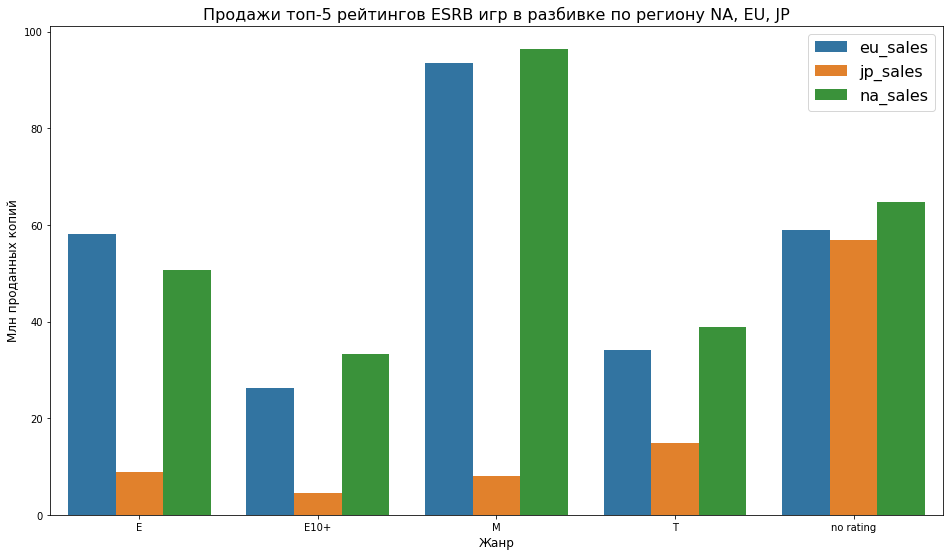

In [66]:
plt.subplots(figsize = (16,9))

sns.barplot(
    data = (
        data_analyzed
        .iloc[:, [0,1,2,3,4,5,6,10]]
        .query( 'rating in["E", "T", "M", "E10+", "no rating"]')
        .melt(id_vars = [  'rating'], value_vars = ['na_sales', 'eu_sales', 'jp_sales'])
        .groupby(['rating', 'variable'])
        .agg(sales = ('value', 'sum'))
        .reset_index()
    ),
    x = 'rating',
    y = 'sales',
    hue = 'variable'
);
plt.title('Продажи топ-5 рейтингов ESRB игр в разбивке по региону NA, EU, JP', fontsize = 16)
plt.xlabel('Жанр', fontsize = 12)
plt.ylabel('Млн проданных копий', fontsize = 12)
plt.legend(fontsize = 16);

In [67]:
# как распределяется рейтинг ESRB в зависимости от жанра
data_analyzed.query('genre in ("Shooter", "Action", "Role-Playing")').groupby([ 'genre', 'rating'])['rating'].count()

genre         rating   
Action        E             35
              E10+          83
              M            118
              T             87
              no rating    296
Role-Playing  E              2
              E10+           9
              M             44
              T             52
              no rating    114
Shooter       E10+          13
              M             76
              T             22
              no rating     17
Name: rating, dtype: int64

- Кажется, что в Японии рейтинг ESRB не особо важен для покупателей, большая часть игр, купленных японскими игроками, не имела рейтнг ESRB. Вероятно, это связано с тем, что в Японии есть собственные рейтинговые ассоциации.
- В США и Европе самые высокие продажи у игр с маркировкой "М" 17+. Проверили, что это соотносится с выводами по популярности различных жанров: большинство так популярных в США и Европе игр в жанре экшн и шутер, имеют такую маркировку ESRB. 

### Проверка гипотез

#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

**H0 гипотеза:** cредние значения user_score для платформ Xbox One и PC равны.

**Альтернативная гипотеза H1:** cредние значения user_score для платформ Xbox One и PC различаются.

Для проверки гипотезы будем использовать двусторонний t-тест для двух независимых выборок с уровнем значимости 5%

In [68]:
alpha = .05

print('Средняя оценка user_score  у платформы XBox One', data_analyzed.query('platform == "XOne"')['user_score'].mean())
print('Средняя оценка user_score  у PC', data_analyzed.query('platform == "PC"')['user_score'].mean())

results = st.ttest_ind(data_analyzed.dropna(subset = ['user_score']).query('platform == "XOne"')['user_score'], data_analyzed.dropna(subset = ['user_score']).query('platform == "PC"')['user_score'])
print('p-value', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу (о равенстве истинного средних значений двух выборок)')
else:
    print('Не можем отвергнуть нулевую гипотезу')


Средняя оценка user_score  у платформы XBox One 6.594545454545454
Средняя оценка user_score  у PC 6.298360655737704
p-value 0.10450507919348415
Не можем отвергнуть нулевую гипотезу


In [69]:
# Комментарий ревьюера
(len(data.dropna().query('platform == "XOne"')['user_score']), 
 len(data.query('platform == "XOne"')['user_score'].dropna()))

(165, 182)

Полученное значение p-value говорит о том, что нулевая гипотеза не может быть отвергнута, поэтому на уровне значимости 5%, можем говорить о том, что пользовательские рейтинги платформ Xbox One и PC одинаковые

#### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

**H0 гипотеза:** cредние значения user_score для жанров Action и Sports равны.

**Альтернативная гипотеза H1:** cредние значения user_score для жанров Action и Sports различаются.

Для проверки гипотезы будем использовать двусторонний t-тест для двух независимых выборок с уровнем значимости 5% 

In [70]:
alpha = .05

print('Средняя оценка user_score  у жанра Action', data_analyzed.query('genre == "Action"')['user_score'].mean())
print('Средняя оценка user_score  у жанра Sports', data_analyzed.query('genre == "Sports"')['user_score'].mean())

results = st.ttest_ind(data_analyzed.dropna(subset = ['user_score']).query('genre == "Action"')['user_score'], data_analyzed.dropna(subset = ['user_score']).query('genre == "Sports"')['user_score'])
print('p-value', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу (о равенстве истинного средних значений двух выборок)')
else:
    print('Не можем отвергнуть нулевую гипотезу')


Средняя оценка user_score  у жанра Action 6.760606060606061
Средняя оценка user_score  у жанра Sports 5.225196850393701
p-value 2.8711147985105864e-19
Отвергаем нулевую гипотезу (о равенстве истинного средних значений двух выборок)


На имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы.

### Общие выводы

Были изучены имеющиеся исторические данные о компьютерных играх за период с 1985 по 2016 год. Данные были очищены от неявныых дубликатов (удалена 1 запись из датасета, явные дубликаты отстутствовали) и обработали пропуски: удалили 2 строки с пропусками в названии игры и 269 строк с пропуском в годе выпуска игры. В результате была удалена очень малая часть данных (272 строки из 16715 - менее 2% данных), удаление данных не повлияло на ход дальнейшего исследования и не исказило выводы. В оценках пользователей, критиков и ESRB присутствовало много пропусков: для пользовательских оценок и оценок критиков оставили пропуски как есть (а это около 50% значений для каждого из столбцов), для рейтинга ESRB сделали замену пропусков на значение no rating, т.к. в датасете представлено много японских игр, которым ассоциация ESRB рейтинг не присваивает.
По предобработанным данным установили, что
- современные игровые платформы, на которых выпускаются игры, имеют характерный  цикл жизни: они "живут" в среднем 9 лет, после чего компании прекращают их поддержку, замещая их более новыми моделями приставок. В течение "жизни" приставки продажи игр для нее сначала растут, достигая пика в середине цикла, а затем падают
- по состоянию на 2016 год самые успешные платформы - PS4 и XBox One. На основании нашего анализа можно ожидать, что и в 2017 году они так и останутся в лидерах
- отзвы пользователей не влияют на продажи, озывы критиков имеют слабо выраженную связь с продажами
- самые популярные игры с рейтингом ESRB "M" (17+)
- популярность жанра зависит от региона пользователей. Пользватели из США и Европы покупают много шутеров и экшн игр: экшенов выпускают много, соответсвенно, и покупют много, но максимальные продажи в среднем на одну игру у жанра  Shooter. Пользователи в Японии предпочитают игры в жанре Roling Play.

Также проверели две статистические гипотезы, а именно:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. По результатам статистического теста сделали вывод, что можем говорить о том, что пользовательские рейтинги платформ Xbox One и PC одинаковые
- Средние пользовательские рейтинги жанров Action и Sports  разные. По результатам статистического теста сделали вывод, что можем говорить о том, что средние пользовательские рейтинги жанров Action и Sports разные


Таким образом, при планировании рекламных кампаний на 2017 год следует делать ставку на следующие игры:
- игры выходят на игровых платформах PS4 и XBox One
- фокус лучше держать на пользователей из США и Европы, они покупают больше
- следует делать ставку на игры в жанре Shooter с рейтингом ESRB "M" (17+) 
- можно ориентироваться на рейтинги критиков, но зависимость продаж от оценки критиков не явно выраженная, так что это точно не первый приоритет
